<h1><center>Проект Анализ возраста</center></h1>

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:


- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
    
    
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задача" data-toc-modified-id="Задача-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задача</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Импорт-модулей" data-toc-modified-id="Импорт-модулей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Импорт модулей</a></span></li><li><span><a href="#Загрузка-и-анализ-данных" data-toc-modified-id="Загрузка-и-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Загрузка и анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Задача

- Постройте и обучите свёрточную нейронную сеть на датасете с фотографиями людей


- Добейтесь значения MAE на тестовой выборке не больше 8.

## Описание данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.
В вашем распоряжении одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age.

## Импорт модулей

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns

## Загрузка и анализ данных

- Загрузм таблицу с изображениями и возрастом

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
labels.info()
display(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


- В таблице представлено 7591 объект, пропусков не наблюдается

- Построим график распределения возраста в выборке

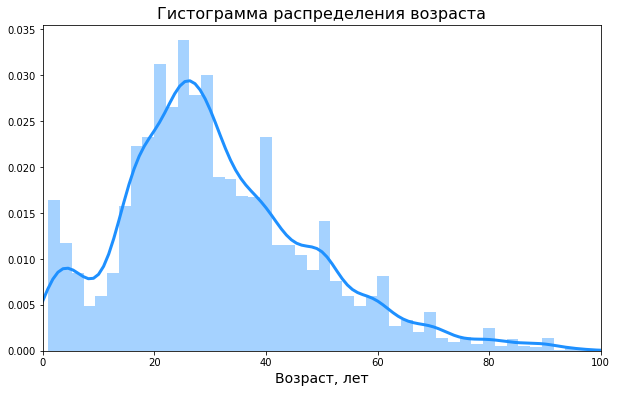

In [6]:
plt.figure(figsize=(10,6))

sns.distplot(labels['real_age'], 
             color="dodgerblue", 
             kde_kws={'linewidth':3})

plt.xlim(0, 100)
plt.xlabel('Возраст, лет', fontsize=14)
plt.title('Гистограмма распределения возраста', fontsize=16)
plt.show()

- Из гистограммы распределния можно сделать вывод, что преоблажающий возраст людей от 18 до 40 лет, также есть вторая преобладающая группа людей до 10 лет,
также есть несколько локальных максимумов в районе 40, 50 и 60 лет

- Рассмотрим первые 10 фотографий предоставленного датасета

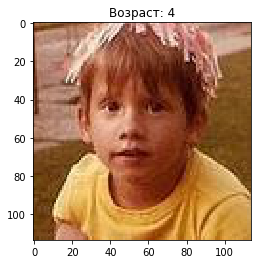

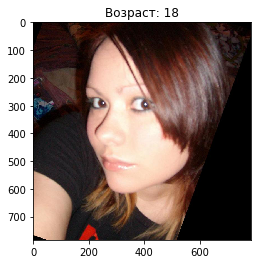

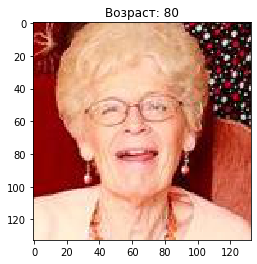

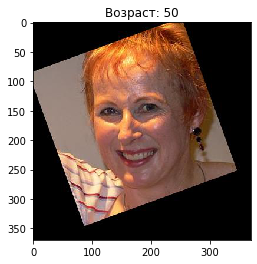

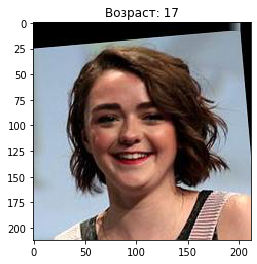

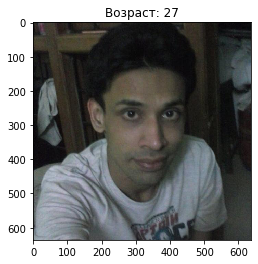

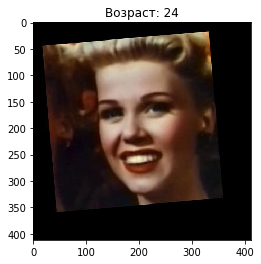

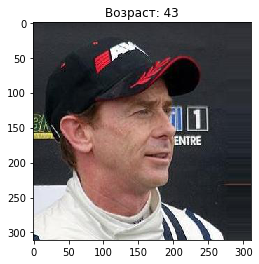

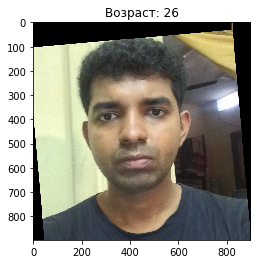

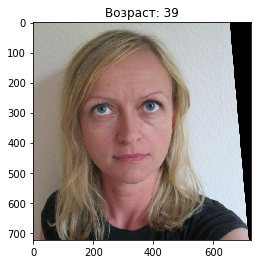

In [7]:
for i in range(10):
    image = Image.open('/datasets/faces/final_files/'+str(labels['file_name'][i]))
    plt.title('Возраст: {:.0f}'.format(labels['real_age'][i]))
    plt.imshow(np.array(image))
    plt.show()

- По этим примерам 10 фоторграфий можно сделать сделать следующие выводы:

    1. Качество фотографий может сильно меняться  
    
    2. Съемка портретная, преимущественно анфас, но встречаются и повороты лица     
    3. Фотографии могут быть обрезанными или повернутыми
    
    4. Размер избражений варьируется

- Применительно к обучению модели на основе исследовательского анализа можно сделать следующие выводы:
    
    1. Размер выборки относительно небольшой, поэтому при использовании например архитектуры сети ResNet50 можно попробовать выбрать веса на предобученном датасете imagenet, также потенциально можно провести дополнительную аугументацию изображений
    2. Выборка по возрасту достаточно представительная, однако для некоторых диапазонов возрастов (~10-18 лет и выше 50-60 лет) обучение может давать более слабые результаты

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

- Рассмотрим код обучения

- Загрузка обучающей и тестовой выборки

```python

def load_train(path):

	labels = pd.read_csv('/datasets/faces/labels.csv')

	train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2, 
                                       horizontal_flip=True)
	
	train_datagen_flow = train_datagen.flow_from_dataframe( 
                                       dataframe=labels, 
									   directory=path + 'final_files/', 
									   x_col='file_name',
									   y_col='real_age',
									   target_size=(224, 224),
									   batch_size=32,
                                       class_mode='raw',
                                       subset='training',
									   seed=12345
									   ) 
                                       
	valid_datagen_flow = train_datagen.flow_from_dataframe( 
                                   dataframe=labels, 
                                   directory=path + 'final_files/', 
                                   x_col='file_name',
                                   y_col='real_age',
                                   target_size=(224, 224),
                                   batch_size=32,
                                   class_mode='raw',
                                   subset='validation',
                                   seed=12345
                                   )      
    
	return train_datagen_flow, valid_datagen_flow
	
	
def load_test(path):

	labels = pd.read_csv('/datasets/faces/labels.csv')

	test_datagen = ImageDataGenerator(rescale=1./255)
	
	test_datagen_flow = test_datagen.flow_from_dataframe( 
                                       dataframe=labels, 
									   directory=path + 'final_files/', 
									   x_col='file_name',
									   y_col='real_age',
									   target_size=(224, 224),
									   batch_size=32,
                                       class_mode='raw',
									   seed=12345
									   ) 
    
	return test_datagen_flow

```

- Функции для загрузки обучающей выборки  имеет один параметр - входной путь до директории с изображениями
- Применяется генератор изображений ImageDataGenerator с масштабированием изображений, аугументацией горизонтальным поворотом и разбиением выборки на обучающую и валидационную в отношении 0.2 соответственно 
- Размер изображений изменяется до стандратного 224х224
- Размер батча используется стандартный - 32
- Для задачи регрессии применяется сlass_mode - "raw"
- На выходе функции два потока с обучающей и валидационной выборками


- Функция загрузки тестовой выборки аналогична, за исключением того, что исходная выборка не разбивается на валидационную часть

- Функция построения модели:

```python
def create_model(input_shape):
	
	backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
					
	
	model = Sequential()
	
	model.add(backbone)
	model.add(GlobalAveragePooling2D())
	model.add(Dense(128, activation='relu')) 
	model.add(Dense(64, activation='relu')) 
	model.add(Dense(1, activation='relu')) 

	optimizer = Adam(lr=0.001)

	model.compile(loss="mean_absolute_error", 
                  optimizer=optimizer, metrics=['mae'])	
	return model

```

- В качестве основы модели использована архитектура ResNet50 без верхних слоев, предобученная на датасете 'imagenet' (в целях повышения качества обучения на относительно небольшой исходной выборке)
- После ResNet50 применяется слой GlobalAveragePooling2D для осреднения характеристик перед каскадом полносвязных слоев
- Далее добавляется два полносвязных слоя с 128 и 64 нейронами
- Для задачи регрессии возраста подходит функция активации relu, т.к. мы работаем с положительными величинами
- Последним идет полносвязный слой с одним нейроном, выход которого будет результатом регрессии 

- Оптмизатор был выбран типа Adam с шагом 0.001
- Функция потерь и итоговая метрика типа "средняя абсолютная ошибка", была выбрана как подходящая для текущей задачи регресии возраста  

- Функция обучения модели:

```python
def train_model(model, train_data, test_data, batch_size=None, epochs=40, steps_per_epoch=None, validation_steps=None):

	train, valid = train_data

	model.fit(train,
              validation_data=valid,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
	print('test loss, test acc:', model.evaluate(test_data, verbose=0))
    
	return model 

```

- Параметры функции обучения модели:
    - model - построенная модель
    - train_data - обучающая и валидацонная выборка (выход функции загрузки обучающей выборки)
    - test_data - тестовая выборка (выход функции загрузки тестовой выборки)
    - batch_size - размер батча (None, т.к. входные выборки уже разбиты на батчи)
    - epoch - количество эпох (40 достаточное количество для достижения хорошего резльтата за разумное время)
    - steps_per_epoch (None - используется полная выборка)
    - validation_steps (None - используется полная выборка)
    
    
- Модель использует обучающую и валидационную выборку для обучения


- После обучения расчитывается значение итоговой метрики на тестовой выборке

- Результаты обучения на каждой эпохе:

```
Train for 190 steps, validate for 48 steps
Epoch 1/40
2021-02-06 14:30:40.501669: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-02-06 14:30:44.759837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 157s - loss: 12.7971 - mae: 12.7978 - val_loss: 13.0080 - val_mae: 12.9721
Epoch 2/40
190/190 - 41s - loss: 10.9309 - mae: 10.9295 - val_loss: 16.0234 - val_mae: 15.9904
Epoch 3/40
190/190 - 40s - loss: 10.4498 - mae: 10.4508 - val_loss: 13.5877 - val_mae: 13.5510
Epoch 4/40
190/190 - 41s - loss: 9.9065 - mae: 9.9057 - val_loss: 12.0263 - val_mae: 11.9845
Epoch 5/40
190/190 - 41s - loss: 9.3121 - mae: 9.3120 - val_loss: 11.9177 - val_mae: 11.8869
Epoch 6/40
190/190 - 41s - loss: 8.7591 - mae: 8.7599 - val_loss: 9.6640 - val_mae: 9.6155
Epoch 7/40
190/190 - 41s - loss: 8.5099 - mae: 8.5102 - val_loss: 13.5574 - val_mae: 13.5330
Epoch 8/40
190/190 - 42s - loss: 8.1364 - mae: 8.1362 - val_loss: 9.8121 - val_mae: 9.8035
Epoch 9/40
190/190 - 41s - loss: 7.8589 - mae: 7.8584 - val_loss: 10.4605 - val_mae: 10.4491
Epoch 10/40
190/190 - 40s - loss: 7.5553 - mae: 7.5566 - val_loss: 8.6374 - val_mae: 8.5734
Epoch 11/40
190/190 - 41s - loss: 7.1573 - mae: 7.1570 - val_loss: 9.9747 - val_mae: 9.9639
Epoch 12/40
190/190 - 41s - loss: 7.0731 - mae: 7.0732 - val_loss: 10.9990 - val_mae: 11.0195
Epoch 13/40
190/190 - 41s - loss: 6.7363 - mae: 6.7366 - val_loss: 11.5351 - val_mae: 11.4843
Epoch 14/40
190/190 - 41s - loss: 6.5113 - mae: 6.5117 - val_loss: 11.6703 - val_mae: 11.6388
Epoch 15/40
190/190 - 42s - loss: 6.1799 - mae: 6.1803 - val_loss: 7.8697 - val_mae: 7.8802
Epoch 16/40
190/190 - 42s - loss: 5.9378 - mae: 5.9385 - val_loss: 8.0820 - val_mae: 8.0663
Epoch 17/40
190/190 - 39s - loss: 5.7791 - mae: 5.7795 - val_loss: 8.3408 - val_mae: 8.3355
Epoch 18/40
190/190 - 40s - loss: 5.5409 - mae: 5.5411 - val_loss: 8.9237 - val_mae: 8.9316
Epoch 19/40
190/190 - 41s - loss: 5.4183 - mae: 5.4187 - val_loss: 9.1358 - val_mae: 9.1112
Epoch 20/40
190/190 - 41s - loss: 5.2245 - mae: 5.2242 - val_loss: 8.8979 - val_mae: 8.8750
Epoch 21/40
190/190 - 42s - loss: 5.1198 - mae: 5.1208 - val_loss: 10.3208 - val_mae: 10.3060
Epoch 22/40
190/190 - 42s - loss: 4.8039 - mae: 4.8038 - val_loss: 8.2202 - val_mae: 8.2117
Epoch 23/40
190/190 - 43s - loss: 4.7181 - mae: 4.7192 - val_loss: 7.7825 - val_mae: 7.7756
Epoch 24/40
190/190 - 40s - loss: 4.5674 - mae: 4.5673 - val_loss: 9.2937 - val_mae: 9.2710
Epoch 25/40
190/190 - 40s - loss: 4.3602 - mae: 4.3609 - val_loss: 7.2255 - val_mae: 7.2358
Epoch 26/40
190/190 - 41s - loss: 4.3254 - mae: 4.3257 - val_loss: 7.9373 - val_mae: 7.9425
Epoch 27/40
190/190 - 42s - loss: 4.0637 - mae: 4.0637 - val_loss: 8.4304 - val_mae: 8.4076
Epoch 28/40
190/190 - 41s - loss: 4.0115 - mae: 4.0122 - val_loss: 8.8123 - val_mae: 8.7841
Epoch 29/40
190/190 - 41s - loss: 3.9706 - mae: 3.9714 - val_loss: 7.4674 - val_mae: 7.4851
Epoch 30/40
190/190 - 42s - loss: 3.6976 - mae: 3.6985 - val_loss: 7.6371 - val_mae: 7.6369
Epoch 31/40
190/190 - 41s - loss: 3.7306 - mae: 3.7304 - val_loss: 8.4653 - val_mae: 8.4448
Epoch 32/40
190/190 - 39s - loss: 3.5831 - mae: 3.5838 - val_loss: 7.4952 - val_mae: 7.4923
Epoch 33/40
190/190 - 41s - loss: 3.5544 - mae: 3.5559 - val_loss: 7.3327 - val_mae: 7.3332
Epoch 34/40
190/190 - 41s - loss: 3.4304 - mae: 3.4311 - val_loss: 8.1293 - val_mae: 8.1165
Epoch 35/40
190/190 - 42s - loss: 3.3036 - mae: 3.3033 - val_loss: 7.5074 - val_mae: 7.5239
Epoch 36/40
190/190 - 42s - loss: 3.2267 - mae: 3.2266 - val_loss: 7.2123 - val_mae: 7.2239
Epoch 37/40
190/190 - 42s - loss: 3.2524 - mae: 3.2534 - val_loss: 7.2208 - val_mae: 7.2201
Epoch 38/40
190/190 - 42s - loss: 3.0875 - mae: 3.0877 - val_loss: 7.7076 - val_mae: 7.7149
Epoch 39/40
190/190 - 40s - loss: 3.1144 - mae: 3.1144 - val_loss: 7.1461 - val_mae: 7.1344
Epoch 40/40
190/190 - 41s - loss: 3.0541 - mae: 3.0538 - val_loss: 7.7499 - val_mae: 7.7415
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
test loss, test acc: [4.59033879011619, 4.5950484]
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 39s - loss: 4.5903 - mae: 4.5950
Test MAE: 4.5950
```

## Анализ обученной модели

- Рассмотрим зачения метрики mae для обучающей и тестовой выборки и время выполнения каждой эпохи

In [16]:
train_mae_samples = [
            12.7978,
            10.9295,
            10.4508,
            9.9057,
            9.312,
            8.7599,
            8.5102,
            8.1362,
            7.8584,
            7.5566,
            7.157,
            7.0732,
            6.7366,
            6.5117,
            6.1803,
            5.9385,
            5.7795,
            5.5411,
            5.4187,
            5.2242,
            5.1208,
            4.8038,
            4.7192,
            4.5673,
            4.3609,
            4.3257,
            4.0637,
            4.0122,
            3.9714,
            3.6985,
            3.7304,
            3.5838,
            3.5559,
            3.4311,
            3.3033,
            3.2266,
            3.2534,
            3.0877,
            3.1144,
            3.0538
            ]

test_mae_samples = [
            12.9721,
            15.9904,
            13.551,
            11.9845,
            11.8869,
            9.6155,
            13.533,
            9.8035,
            10.4491,
            8.5734,
            9.9639,
            11.0195,
            11.4843,
            11.6388,
            7.8802,
            8.0663,
            8.3355,
            8.9316,
            9.1112,
            8.875,
            10.306,
            8.2117,
            7.7756,
            9.271,
            7.2358,
            7.9425,
            8.4076,
            8.7841,
            7.4851,
            7.6369,
            8.4448,
            7.4923,
            7.3332,
            8.1165,
            7.5239,
            7.2239,
            7.2201,
            7.7149,
            7.1344,
            7.7415
            ]

time_per_epoch_samples = [
                    157,
                    41,
                    40,
                    41,
                    41,
                    41,
                    41,
                    42,
                    41,
                    40,
                    41,
                    41,
                    41,
                    41,
                    42,
                    42,
                    39,
                    40,
                    41,
                    41,
                    42,
                    42,
                    43,
                    40,
                    40,
                    41,
                    42,
                    41,
                    41,
                    42,
                    41,
                    39,
                    41,
                    41,
                    42,
                    42,
                    42,
                    42,
                    40,
                    41,
                ]

test_mae = 4.595

In [9]:
result_data = {'mae_train':train_mae_samples, 'mae_test':test_mae_samples, 'time_per_epoch, s':time_per_epoch_samples}
train_results = pd.DataFrame(data=result_data).round(2)
train_results.index.name = 'epoch'
train_results.index += 1 
print('\n--------Таблица результатов тестирования-------')
display(train_results)


--------Таблица результатов тестирования-------


,mae_train,mae_test,"time_per_epoch, s"
epoch,,,
1,12.80,12.97,157
2,10.93,15.99,41
3,10.45,13.55,40
4,9.91,11.98,41
5,9.31,11.89,41
6,8.76,9.62,41
7,8.51,13.53,41
8,8.14,9.80,42
9,7.86,10.45,41


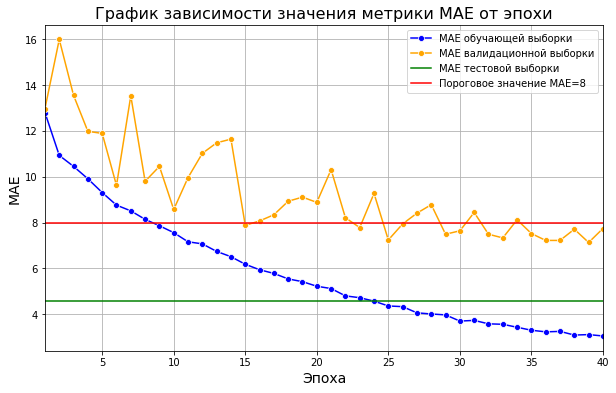


Среднее время одной эпохи составляет: 44 сек

Общее время обучения составляет: 1759 сек


In [21]:
plt.figure(figsize=(10,6))

sns.lineplot(x=train_results.index.values, y=train_results['mae_train'], color='blue', marker='o', label='MAE обучающей выборки')
sns.lineplot(x=train_results.index.values, y=train_results['mae_test'], color='orange', marker='o', label='MAE валидационной выборки')
sns.lineplot(x=train_results.index.values, y=test_mae, color='green', label='MAE тестовой выборки')
sns.lineplot(x=train_results.index.values, y=8, color='red', label='Пороговое значение MAE=8')

plt.xlim(1, 40)
plt.xlabel('Эпоха', fontsize=14)
plt.ylabel('MAE', fontsize=14)

plt.title('График зависимости значения метрики MAE от эпохи', fontsize=16)
plt.grid()
plt.show()


print('\nСреднее время одной эпохи составляет: {:.0f} сек'.format(train_results['time_per_epoch, s'].mean()))
print('\nОбщее время обучения составляет: {:.0f} сек'.format(train_results['time_per_epoch, s'].sum()))

- Как видно из графика зависимости значения метрики MAE - после 35 эпохи ошибка на валидационной выборке стабильно меньше порогового значения MAE=8


- С 35 по 40 эпоху MAE валидационной выборки не становится лучше, таким образом большее количество эпох не внесет значительный вклад в улучшение результатов модели


- Среднее время одной эпохи составляет 44 секунды


- Общее время обучения составляет 1759 секунд

## Общий вывод

- Полученная модель полностью удовлетворяет условиям поставленной задачи и может послужить хорошим инструментом в развитии бизнеса в области анализа покупок и составлении рекомендаций о товарах


- Что касается использования модели для оценки добросовестности кассиров при продаже алкоголя, то здесь стоит отметить два пункта:
    1. Погрешность предсказания моедли в ~4.5 года может в целом считаться достаточно высокой для подобной задачи 
    2. Как было отмечено ранее, группа людей до 18 лет достаточно мало представлена в исходной выборке, что может негативно сказаться на предскзании возраста людей из по сути целевой для подобной задачи группы. Моя рекомендация для качественного решения этой задачи - использовать более представительную выборку особенно в категории до 30 лет (либо путем добавления материалов, либо средствами аугументации) и стремиться к достижению прогрешности модели в 1-2 года